In [1]:
import numpy as np

import matplotlib.pyplot as plt

# [TODO][IMPORTANT] Always, the convergence of solution with respect to the time steps is crucial

# [TODO] Possible improvement:

- the initial guess when finding the root during `find_dx()`
- put `jac` for finding root during `find_dx()`

In [2]:
from scipy.optimize import root

def find_dx(f, dx_df, tn, xn, dt, callback=None, disp=False):
    """Find `dx` such that `x_{n+1} = x_{n} + dx`"""
    
    def _g(_dx, _f, _dx_df, _tn, _xn, _dt):
        return -_dx + _dt * _f(_tn+_dt, _xn+_dx)
    
    def _jac_g(_dx, _f, _dx_df, _tn, _xn, _dt):
        return -1 + _dt * _dx_df(_tn+_dt, _xn+_dx)
    
    _dx0 = np.array([0.0], dtype=float)
    _g_args = (f, dx_df, tn, xn, dt)


    ## Configure 'hybr' method
#     _method = 'hybr'
#     _method_opts = {'xtol':1.49012e-08, 'maxfev':0, 'factor':100}
#     _total_opts = {'method':_method, 'jac':_jac_g, 'options':_method_opts}
    
    
    ## Configure 'broyden1' method
    _method = 'broyden1'
    _method_opts = {'disp':disp, 'fatol':6e-6}
    
    if callable(callback):
        def _callback(x,f):
            callback(x,f)
            print("[ ] ", tn,xn,dt,_dx0)
    else: _callback = None
        
    _total_opts = {'method':_method, 'options':_method_opts, 'callback':_callback}
        
    
    ## Search for root
    _sol = root(_g, _dx0, args=_g_args, **_total_opts)
    
    
    ## Check found root
    if _sol.success: return _sol.x
    else: raise RuntimeError(
        "Failed to find `dx` with result:\n{}".format(_sol))

# Define problem

In [3]:
def f(t,x):
    return x

def dx_df(t,x):
    return np.full_like(x, 1.0)

In [4]:
from numpy import exp
def xt_ana(t, x0):
    return x0 * exp(t-t[0])

In [5]:
DELTA_T_SETUP_MAX_ITER_NUM = 50
DELTA_T_REDUCTION_RATIO = 0.8

# Solve

In [6]:
t0 = 0.0
dt = 0.1
N_t = 51

xp_t0_arr = np.array([-0.5, 0.0, 1.0, 1.5])

In [7]:
t_arr = t0 + dt * np.arange(N_t)

xp_t_arr = np.empty((t_arr.size, xp_t0_arr.size), dtype=float)
xp_t_arr[0,:] = xp_t0_arr

Nt, Np = t_arr.size, xp_t0_arr.size

#### For Debugging

In [8]:
def callback(xx,ff): print("[ ] {:.28f}, {:.28f}".format(xx[0],ff[0]))

import warnings
warnings.filterwarnings("error")

##### Solve for each particle

In [9]:
xp_arr = xp_t0_arr.copy()

_t = t_arr[0]

for nt in range(t_arr.size-1):
    
    assert abs(_t - t_arr[nt]) < 1e-10
    _t = t_arr[nt]
    
    for nt_sub in range(DELTA_T_SETUP_MAX_ITER_NUM):
        _reach_next_t = True
        
        
        ## Determine `_dt`
        _dt = t_arr[nt+1] - _t
        assert _dt > 0
        for xp in xp_arr:
            for nt_sub_sub in range(DELTA_T_SETUP_MAX_ITER_NUM):
                if 1.0 - _dt*dx_df(t_arr[nt]+_dt,xp) > 0.0: break
                print(_dt)
                _reach_next_t = False
                _dt *= DELTA_T_REDUCTION_RATIO
        
        
        ## Propagate each particle's position by `_dt`
        for ip in range(xp_arr.size):
            try: _dx = find_dx(f, dx_df, _t, xp_arr[ip], _dt)
            except:
                try: _dx = find_dx(f, dx_df, _t, xp_arr[ip], _dt, callback=callback, disp=True)
                except Exception: pass
                _msg="Failed to evaluate `_dx` at t={:.4f},xp0={:.4f},xp={:.4f}"
                raise Exception(_msg.format(_t,xp_t0_arr[ip],xp_arr[ip]))
            xp_arr[ip] += _dx
        _t += _dt
        
        
        ## Repeat the above procedure until time reaches the next timestep
        if _reach_next_t: break
            
            
    xp_t_arr[nt+1,:] = xp_arr

#### Find analytical solution for each particle

In [10]:
xp_t_ana_arr = np.empty_like(xp_t_arr)
for ip in range(Np):
    xp_t_ana_arr[:,ip] = xt_ana(t_arr, xp_t_arr[0,ip])

#### Visualize

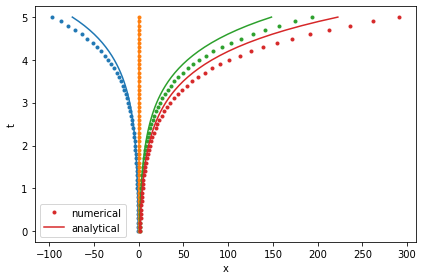

In [11]:
fig, ax = plt.subplots()
for ip in range(Np):
    l_num, = ax.plot(xp_t_arr[:,ip], t_arr, '.')
    l_ana, = ax.plot(xp_t_ana_arr[:,ip],t_arr, color=l_num.get_color())
ax.set_xlabel("x"), ax.set_ylabel("t")
ax.legend([l_num,l_ana], ["numerical", "analytical"])
fig.tight_layout()
# fig.savefig("f=x-with-dt-{}-test-4.png".format(dt))